## Project

In [ ]:
%cd toto/toto

In [ ]:
import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import mean_absolute_error, mean_squared_error

from data.util.dataset import MaskedTimeseries
from inference.forecaster import TotoForecaster
from model.toto import Toto

In [ ]:
# Configuration
CONFIG = {
    'device': 'cuda',
    'context_length': 4096,
    'prediction_length': 48,
    'interval_seconds': 60 * 60  # 1 hour
}

# Colors
DARK_GREY = "#1c2b34"
BLUE = "#3598ec"
PURPLE = "#7463e1"
LIGHT_PURPLE = "#d7c3ff"
PINK = "#ff0099"

### Data Preparation


In [ ]:
def load_data(path, filename):
    df = pd.read_csv(os.path.join(path, filename))
    feature_columns = df.columns.tolist()
    feature_columns.remove('timestamp_seconds')
    return df, feature_columns

In [ ]:
def prepare_data(df, feature_columns, config):
    n_variates = len(feature_columns)
    input_df = df.iloc[-(config['context_length'] + config['prediction_length']):-config['prediction_length']]
    target_df = df.iloc[-config['prediction_length']:]

    input_series = torch.from_numpy(input_df[feature_columns].values.T).to(torch.float).to(config['device'])
    timestamp_seconds = torch.from_numpy(input_df.timestamp_seconds.values.T) \
        .expand((n_variates, config['context_length'])).to(config['device'])
    time_interval_seconds = torch.full((n_variates,), config['interval_seconds']).to(config['device'])

    inputs = MaskedTimeseries(
        series=input_series,
        padding_mask=torch.full_like(input_series, True, dtype=torch.bool),
        id_mask=torch.zeros_like(input_series),
        timestamp_seconds=timestamp_seconds,
        time_interval_seconds=time_interval_seconds,
    )

    return input_df, target_df, inputs

### Model Inference

In [ ]:
def run_inference(inputs, config):
    toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0')
    toto.to(config['device'])
    toto.compile()

    forecaster = TotoForecaster(toto.model)
    forecast = forecaster.forecast(
        inputs,
        prediction_length=config['prediction_length'],
        num_samples=256,
        samples_per_batch=8,
        use_kv_cache=True,
    )
    return forecast

### Performance


#### Metrics

In [ ]:
def evaluate_forecast(target_df, forecast):
    point_forecast = np.median(forecast.samples.squeeze()[0].cpu().numpy(), axis=-1)
    ground_truth = target_df["cnt"].values
    mae = mean_absolute_error(ground_truth, point_forecast)
    rmse = np.sqrt(mean_squared_error(ground_truth, point_forecast))
    print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}")
    return point_forecast, ground_truth

#### Visualization

In [ ]:
def visualize_forecast(input_df, target_df, forecast, point_forecast, dataset_label):
    # Convert timestamps
    input_df["datetime"] = pd.to_datetime(input_df["timestamp_seconds"], unit="s")
    target_df["datetime"] = pd.to_datetime(target_df["timestamp_seconds"], unit="s")
    feature = "cnt"

    matplotlib.rc("axes", edgecolor=DARK_GREY)
    fig = plt.figure(figsize=(12, 6), layout="tight", dpi=150)
    plt.suptitle(f"Toto Forecast for '{feature}' by {dataset_label}")

    plt.tick_params(axis="x", color=DARK_GREY, labelcolor=DARK_GREY)
    plt.tick_params(axis="y", color=DARK_GREY, labelcolor=DARK_GREY)
    plt.ylabel(feature)
    plt.xlim(input_df.datetime.iloc[-120], target_df.datetime.iloc[-1])
    plt.axvline(target_df.datetime.iloc[0], color=PINK, linestyle=":")

    plt.plot(input_df["datetime"], input_df[feature], color=BLUE, label="History")
    plt.plot(target_df["datetime"], target_df[feature], color=BLUE, label="Ground Truth")
    plt.plot(target_df["datetime"], point_forecast, color=PURPLE, linestyle="--", label="Median Forecast")

    alpha = 0.05
    qs = forecast.samples.quantile(q=torch.tensor([alpha, 1 - alpha], device=forecast.samples.device), dim=-1)
    plt.fill_between(
        target_df["datetime"],
        qs[0].squeeze()[0].cpu(),
        qs[1].squeeze()[0].cpu(),
        color=LIGHT_PURPLE,
        alpha=0.8,
        label=f"{int((1 - 2 * alpha) * 100)}% Prediction Interval",
    )

    plt.legend()
    plt.show()

    # Residual plot
    residuals = target_df["cnt"].values - point_forecast
    plt.figure(figsize=(12, 4))
    plt.plot(target_df["datetime"], residuals, color="red")
    plt.axhline(0, linestyle="--", color="black")
    plt.ylabel("Residuals")
    plt.xlabel("Time")
    plt.title(f"Forecast Residuals by {dataset_label}")
    plt.show()

In [ ]:
def plot_residuals_comparison(datetimes_list, residuals_list, labels):
    plt.figure(figsize=(12, 4))
    for datetimes, residuals, label in zip(datetimes_list, residuals_list, labels):
        plt.plot(datetimes, residuals, label=f"{label} Residuals")
    plt.axhline(0, linestyle="--", color="black")
    plt.ylabel("Residuals")
    plt.xlabel("Time")
    plt.title("Forecast Residuals Comparison")
    plt.legend()
    plt.show()

### Main

In [ ]:
def run_pipeline(path, filename, dataset_label):
    print(f"Processing {dataset_label} Data...")
    df, feature_columns = load_data(path, filename)
    input_df, target_df, inputs = prepare_data(df, feature_columns, CONFIG)
    forecast = run_inference(inputs, CONFIG)
    point_forecast, ground_truth = evaluate_forecast(target_df, forecast)
    visualize_forecast(input_df, target_df, forecast, point_forecast, dataset_label)
    residuals = ground_truth - point_forecast
    datetimes = pd.to_datetime(target_df["timestamp_seconds"], unit="s")
    return datetimes, residuals

Processing Original Data...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

MAE: 39.814, RMSE: 62.990


<ipython-input-10-86e072ee5c16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df["datetime"] = pd.to_datetime(input_df["timestamp_seconds"], unit="s")
<ipython-input-10-86e072ee5c16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df["datetime"] = pd.to_datetime(target_df["timestamp_seconds"], unit="s")


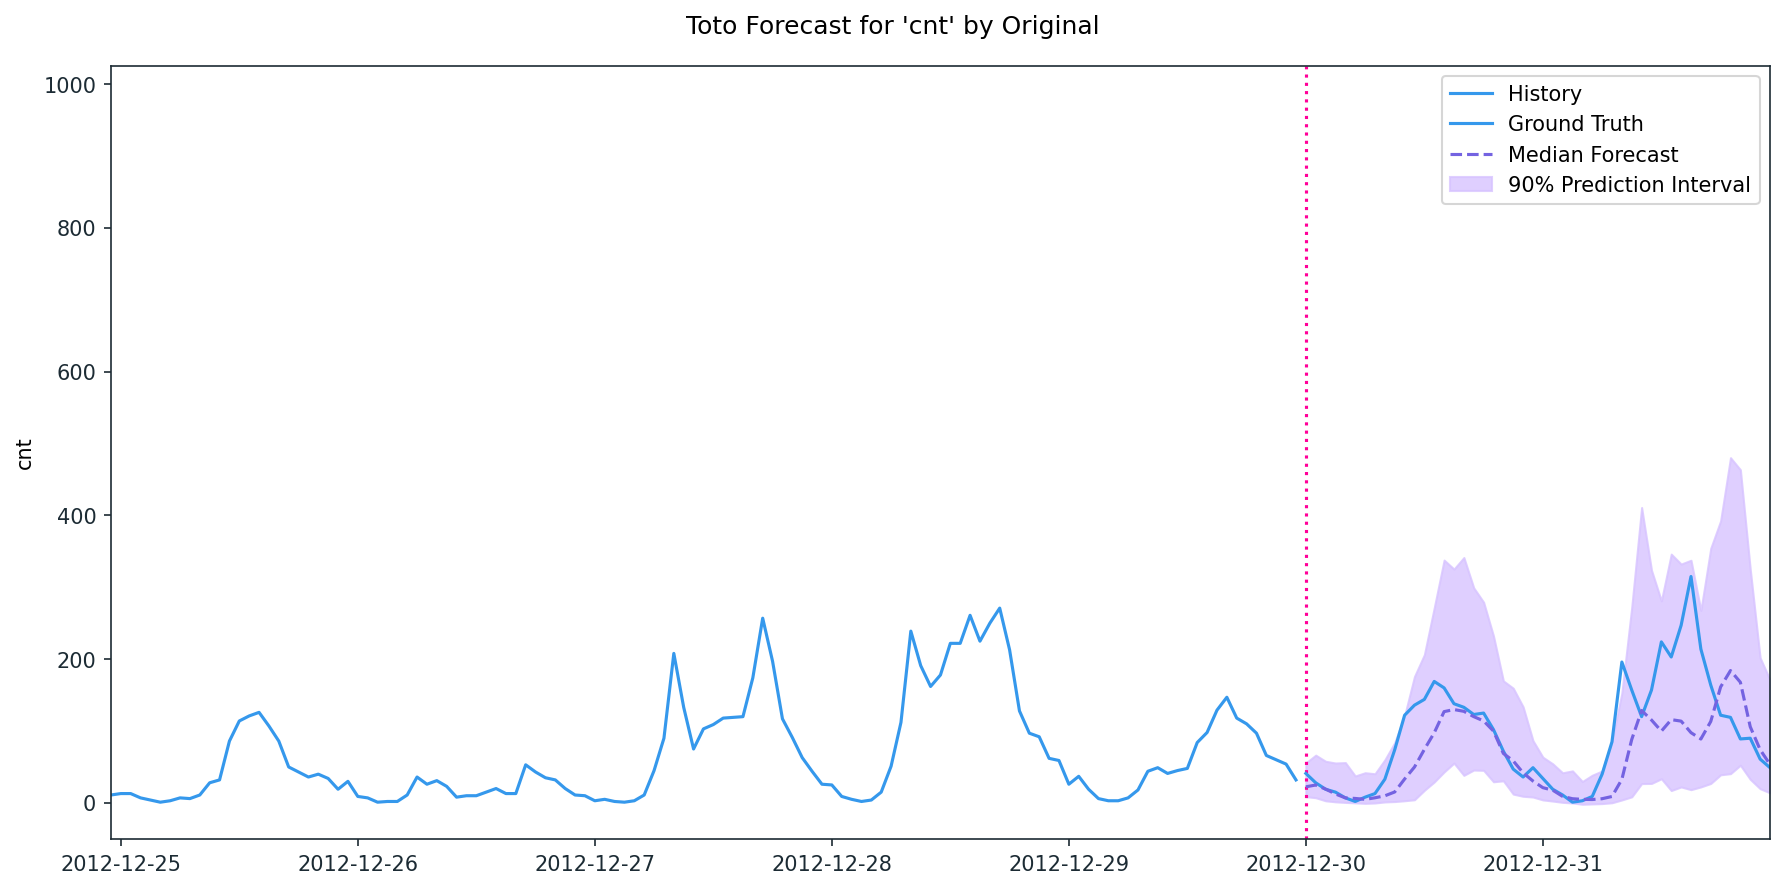

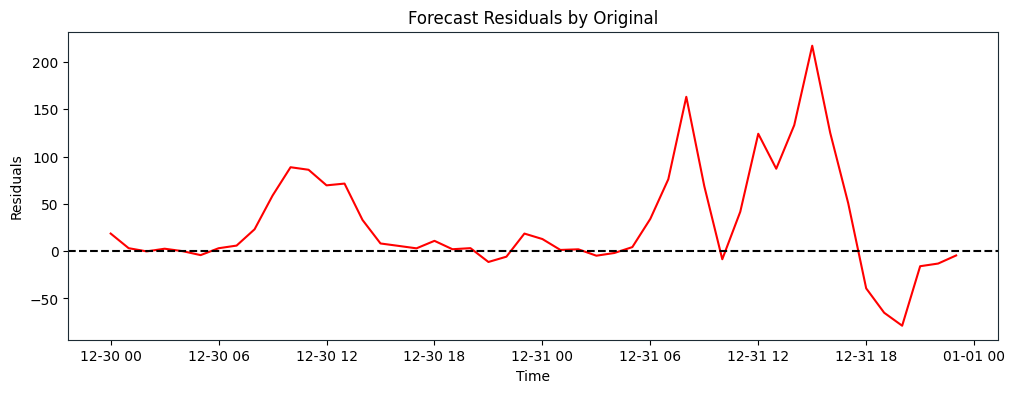

Processing Transformed Data...
MAE: 40.510, RMSE: 60.918


<ipython-input-10-86e072ee5c16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df["datetime"] = pd.to_datetime(input_df["timestamp_seconds"], unit="s")
<ipython-input-10-86e072ee5c16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df["datetime"] = pd.to_datetime(target_df["timestamp_seconds"], unit="s")


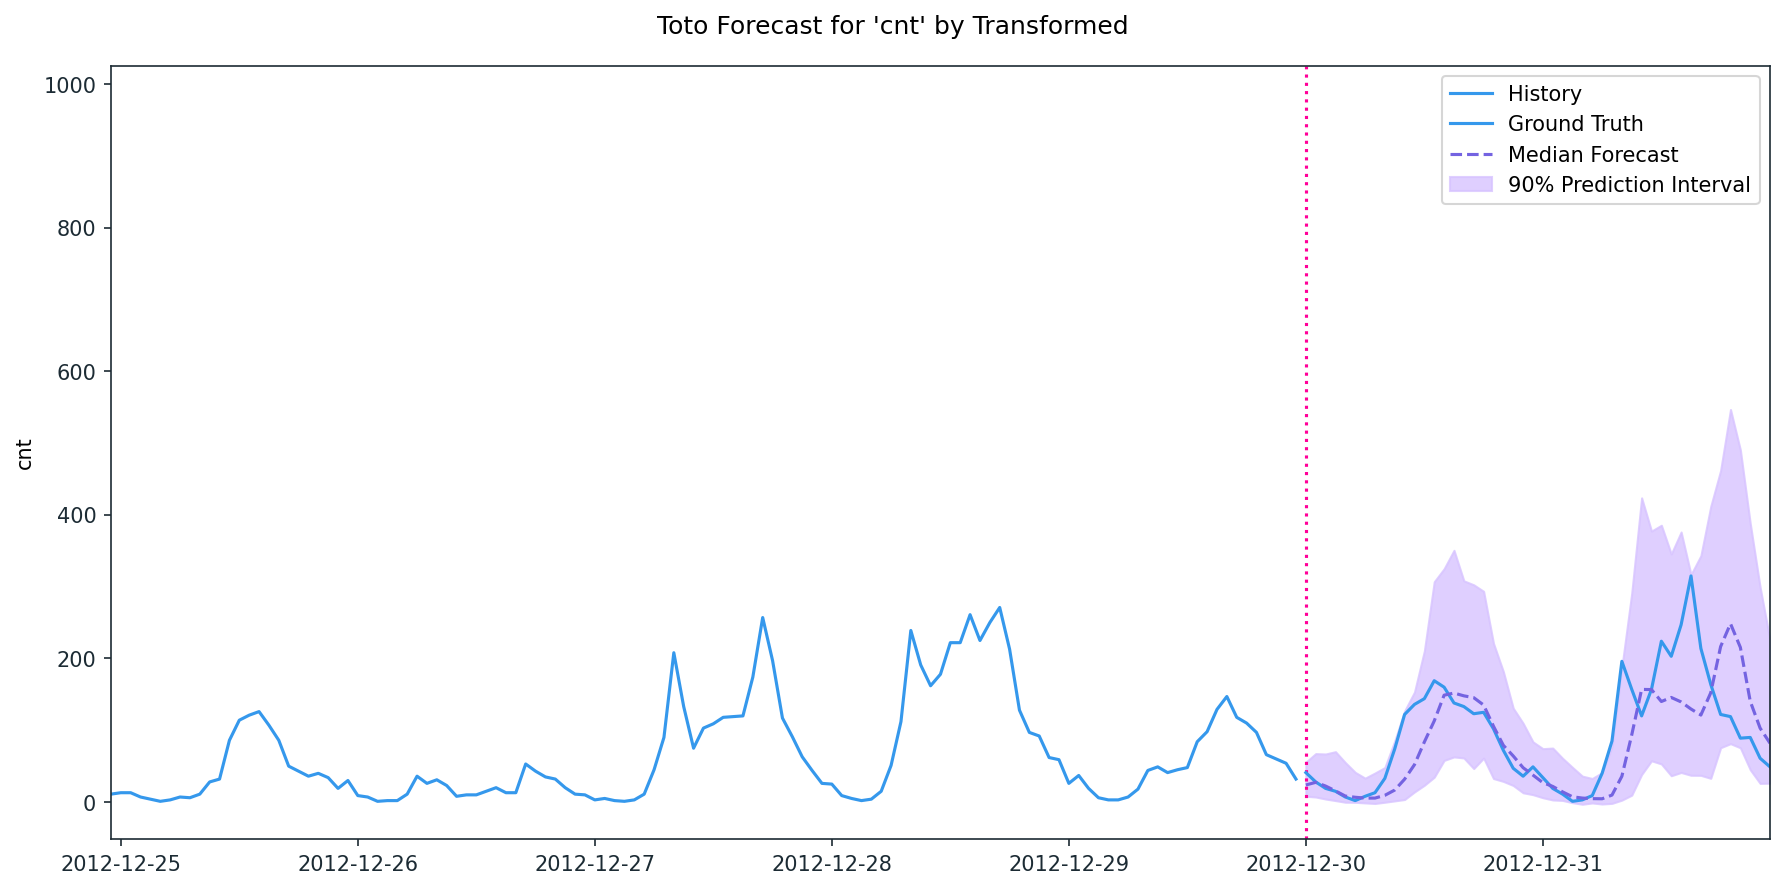

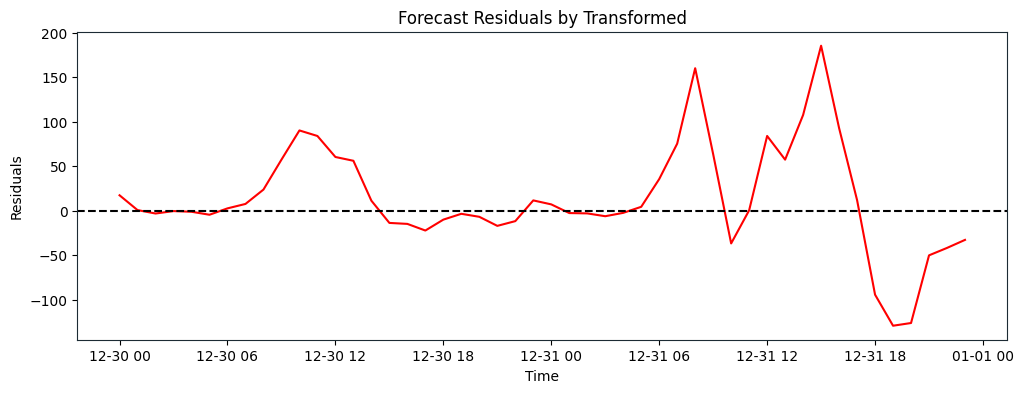

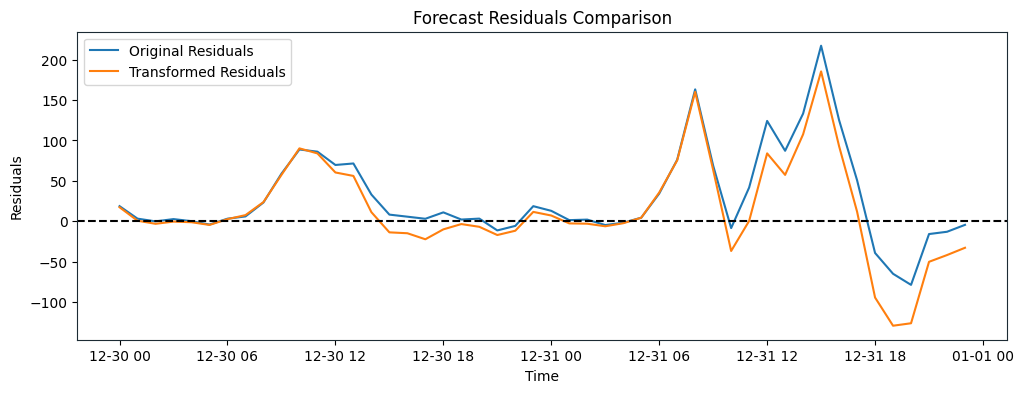

In [ ]:
if __name__ == "__main__":
    PATH = "../../" # Adjust the path to your data directory

    orig_datetimes, orig_residuals = run_pipeline(PATH, "hour_base.csv", "Original")
    trans_datetimes, trans_residuals = run_pipeline(PATH, "hour_transformed.csv", "Transformed")

    plot_residuals_comparison(
        [orig_datetimes, trans_datetimes],
        [orig_residuals, trans_residuals],
        ["Original", "Transformed"]
    )